# Gaussian impurity with self consistency

In [1]:
import kwant
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from numpy import linalg as la
from amsc import (
    bulk_amsc_system,
    generate_intial_Delta,
    setup_gaussian_impurities,
)
from plot_tools import add_tl_label
from tqdm.notebook import tqdm
from pauli import *
from qm_tools import sort_eigensystem
from qm_tools import thermal_broadening, sparse_diag
from scipy.interpolate import RegularGridInterpolator

In [2]:
# eigsh = sla.eigsh
eigsh = sparse_diag 

In [3]:
plt.style.use("../plot_style.mplstyle")

In [8]:
periodic_bc = False

Nx = 81
Ny = 81

x_ax = np.linspace(-(Nx // 2), (Nx // 2), Nx)
y_ax = np.linspace(-(Ny // 2), (Ny // 2), Ny)
x, y = np.meshgrid(x_ax, y_ax)

t = 5.0
t_so = 0.0 * t
t_am = 0.25 * t

mu = 2.5
hz0 = 1e-6
hx0 = 0
hy0 = 0

## Initial value for Delta (will be used to determine g)
Delta_init = 1

## Self consistency

In [19]:
N = 800

In [20]:
# Impurituy positions
impurity_positions = [(0, 0)]  # , (-10, 0)]
impurity_sizes = [2.4]
impurity_eccentricities = [0.0]  # Eccentricity
impurity_orientation = [0.0]  # Orientation

hx_imp = [0.0]  # Impurity field
hy_imp = [0.0]  # Impurity field
hz_imp = [0.0]  # Impurity field

In [21]:
vortex_positions = []
windings = []
l_core = 0  # l_core is the decay length of the order parameter (in a vortex that is the coherence length)

Delta, theta = generate_intial_Delta(
    x=x,
    y=y,
    Delta_init=Delta_init,
    vortex_positions=vortex_positions,
    windings=windings,
    l_core=l_core,
)

In [22]:
def solve_for_V(Vs, 
                Delta_0=Delta, theta_0=theta,
                tol = 1e-6,
                maxiter=10,
                mixing = 0.7, 
                T = 0.001,):
    """
    Solve the self-consistent problem for an impurity in an altermagnetic superconductor
    for a given value of Vs.
    """

    # Define the potential field
    V, hx, hy, hz = setup_gaussian_impurities(
            x=x,
            y=y,
            mu=mu,
            hx0=hx0,
            hy0=hy0,
            hz0=hz0,
            impurity_sizes=impurity_sizes,
            impurity_positions=impurity_positions,
            impurity_eccentricities=impurity_eccentricities,
            impurity_orientations=impurity_orientation,
            V_imp=[Vs],
            hx_imp=hx_imp,
            hy_imp=hy_imp,
            hz_imp=hz_imp,
        )

    # Create the system
    def create_system(Delta, theta):
        syst, lat = bulk_amsc_system(
            Nx=Nx,
            Ny=Ny,
            t=t,
            t_so=t_so,
            t_am=t_am,
            V=V,
            Delta=Delta,
            theta=theta,
            hx=hx,
            hy=hy,
            hz=hz,
            periodic_bc=periodic_bc,
        )

        return syst.finalized()
    
    fsyst = create_system(Delta_0, theta_0)

    # Singlet correlations operator
    txs0_op = kwant.operator.Density(fsyst, onsite=txs0, sum=False)
    tys0_op = kwant.operator.Density(fsyst, onsite=tys0, sum=False)


    # First diagonalization
    print("First diagonalization")
    ws, vs = eigsh(fsyst.hamiltonian_submatrix(sparse=True), k=N, sigma=0)
    sort_idxs = np.argsort(ws)
    vs = vs[:, sort_idxs]
    ws = ws[sort_idxs]

    omega_cutoff = ws[-1]
    print(f"The energy cutoff is {omega_cutoff:5.3f}")

    if omega_cutoff < Delta_init + t_am / t * mu:
        print("Warning: cutoff too low!")

    # Calculate correlation functions
    txs0_ev = np.zeros((N, Nx * Ny))
    tys0_ev = np.zeros((N, Nx * Ny))
    for i in range(N):
        txs0_ev[i] = txs0_op(vs[:, i])
        tys0_ev[i] = tys0_op(vs[:, i])

    Fx = np.einsum("ni, n -> i", txs0_ev, np.tanh(ws / (2 * T)))
    Fy = np.einsum("ni, n -> i", tys0_ev, np.tanh(ws / (2 * T)))


    # Calculate coupling constant
    g = Delta_init / np.mean(np.sqrt(Fx**2 + Fy**2))
    print(f"The coupling constant is {g:5.3f}")

    Delta_n = g * np.sqrt(Fx**2 + Fy**2)
    theta_n = np.arctan2(Fy, Fx)

    Delta_interp = RegularGridInterpolator((y_ax, x_ax), Delta_n.reshape(Ny, Nx))
    theta_interp = RegularGridInterpolator((y_ax, x_ax), theta_n.reshape(Ny, Nx))

    Delta = lambda x, y: Delta_interp((y, x))
    theta = lambda x, y: theta_interp((y, x))

    for iter_number in range(maxiter):
        # Create a new system with the new order parameter
        fsyst = create_system(
            Delta=Delta,
            theta=theta,
        )

        # Diagonalize the sytem
        ws, vs = eigsh(fsyst.hamiltonian_submatrix(sparse=True), k=N, sigma=0)

        sort_idxs = np.argsort(ws)
        vs = vs[:, sort_idxs]
        ws = ws[sort_idxs]

        # Calculate correlation functions
        txs0_ev = np.zeros((N, Nx * Ny))
        tys0_ev = np.zeros((N, Nx * Ny))
        for i in range(N):
            txs0_ev[i] = txs0_op(vs[:, i])
            tys0_ev[i] = tys0_op(vs[:, i])

        Fx = np.einsum("ni, n -> i", txs0_ev, np.tanh(ws / (2 * T)))
        Fy = np.einsum("ni, n -> i", tys0_ev, np.tanh(ws / (2 * T)))

        # Calculate the order parameter
        Delta_n_new = g * np.sqrt(Fx**2 + Fy**2)
        theta_n_new = np.arctan2(Fy, Fx)

        Delta_n = (1 - mixing) * Delta_n + mixing * Delta_n_new
        theta_n = (1 - mixing) * theta_n + mixing * Delta_n_new

        diff = np.mean((Delta_n.reshape(Nx, Ny) - Delta(x, y)) ** 2)
        print(f"Iteration {iter_number:2d}, the average error is: {diff:5f}")

        # Create the new interpolation functions
        Delta_interp = RegularGridInterpolator((y_ax, x_ax), Delta_n.reshape(Ny, Nx))
        theta_interp = RegularGridInterpolator((y_ax, x_ax), theta_n.reshape(Ny, Nx))

        # Update the order parameter
        Delta = lambda x, y: Delta_interp((y, x))
        theta = lambda x, y: theta_interp((y, x))

        if diff < tol:
            break

    return Delta, theta, ws, vs

In [23]:
Delta_sc, theta_sc, ws_sc, vs_sc = solve_for_V(-16)

First diagonalization
The energy cutoff is 1.849
The coupling constant is 6.302
Iteration  0, the average error is: 0.000618
Iteration  1, the average error is: 0.000050
Iteration  2, the average error is: 0.000008
Iteration  3, the average error is: 0.000002
Iteration  4, the average error is: 0.000000


(<function __main__.solve_for_V.<locals>.<lambda>(x, y)>,
 <function __main__.solve_for_V.<locals>.<lambda>(x, y)>,
 array([-1.85634735, -1.85634535, -1.85609311, -1.85609111, -1.85584981,
        -1.85584781, -1.84645717, -1.84645517, -1.84510227, -1.84510027,
        -1.84129807, -1.84129607, -1.8309845 , -1.8309825 , -1.82737229,
        -1.82737029, -1.82196299, -1.82196099, -1.8025069 , -1.8025049 ,
        -1.79505079, -1.79504879, -1.78987331, -1.78987131, -1.78529292,
        -1.78529092, -1.78458876, -1.78458676, -1.77529766, -1.77529566,
        -1.76831475, -1.76831275, -1.76537662, -1.76537462, -1.76172415,
        -1.76172215, -1.75984715, -1.75984515, -1.74953291, -1.74953091,
        -1.74477022, -1.74476822, -1.74084867, -1.74084667, -1.7407543 ,
        -1.7407523 , -1.73872245, -1.73872045, -1.72674027, -1.72673827,
        -1.72080765, -1.72080565, -1.71202666, -1.71202466, -1.71080158,
        -1.71079958, -1.70858766, -1.70858566, -1.70069736, -1.70069536,
        

In [ ]:
fig, ax = plt.subplots()
ax.plot(-Vss, wss)
ax.set_xlabel(r"$-V_0$")
ax.set_ylabel(r"$\omega_n$")

ax.set_ylim(-0.5, 0.5)
# ax.set_xlim(10, 30)

fig.savefig("./images/self-consistency-off.svg")

## Non-self consistency

In [26]:
N = 20

In [27]:
vortex_positions = []
windings = []
l_core = 0  # l_core is the decay length of the order parameter (in a vortex that is the coherence length)

Delta, theta = generate_intial_Delta(
    x=x,
    y=y,
    Delta_init=Delta_init,
    vortex_positions=vortex_positions,
    windings=windings,
    l_core=l_core,
)

In [35]:
P = 21
Vss = np.linspace(0, 20, P)
wss = np.zeros((P, N))

for i, Vs in tqdm(enumerate(Vss), total=len(Vss)):

    V, hx, hy, hz = setup_gaussian_impurities(
        x=x,
        y=y,
        mu=mu,
        hx0=hx0,
        hy0=hy0,
        hz0=hz0,
        impurity_sizes=[2.4],
        impurity_positions=impurity_positions,
        impurity_eccentricities=impurity_eccentricities,
        impurity_orientations=impurity_orientation,
        V_imp=[Vs],
        hx_imp=hx_imp,
        hy_imp=hy_imp,
        hz_imp=hz_imp,
    )

    syst, lat = bulk_amsc_system(
        Nx=Nx,
        Ny=Ny,
        t=t,
        t_so=t_so,
        t_am=t_am,
        V=V,
        Delta=Delta,
        theta=theta,
        hx=hx,
        hy=hy,
        hz=hz,
        periodic_bc=periodic_bc,
    )

    fsyst = syst.finalized()

    ws, vs = eigsh(fsyst.hamiltonian_submatrix(sparse=True), k=N, sigma=0)

    wss[i] = ws

  0%|          | 0/21 [00:00<?, ?it/s]

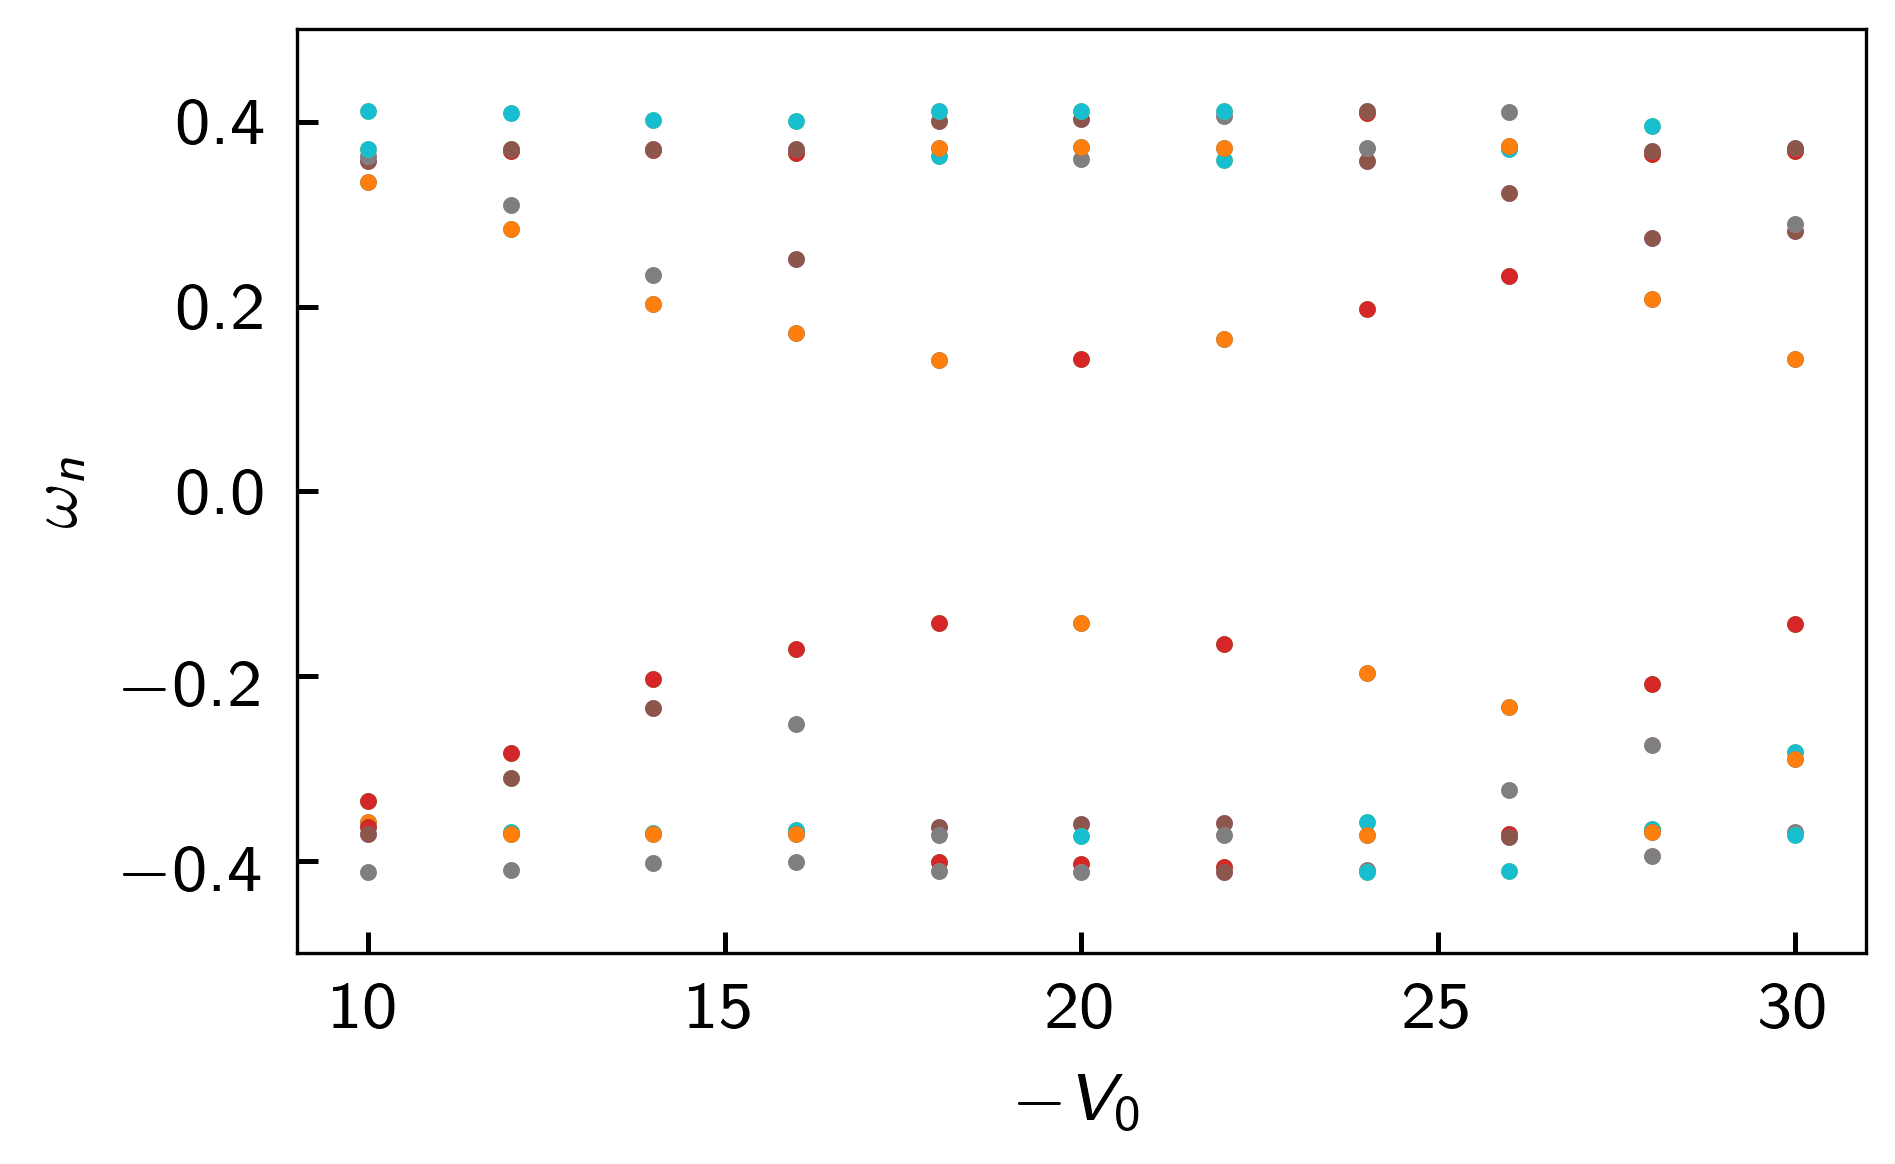

In [ ]:
fig, ax = plt.subplots()
ax.plot(-Vss, wss, '.')
ax.set_xlabel(r"$-V_0$")
ax.set_ylabel(r"$\omega_n$")

ax.set_ylim(-0.5, 0.5)
# ax.set_xlim(10, 30)

fig.savefig("./imgs/self-consistency-off.svg")

(-0.5, 0.5)

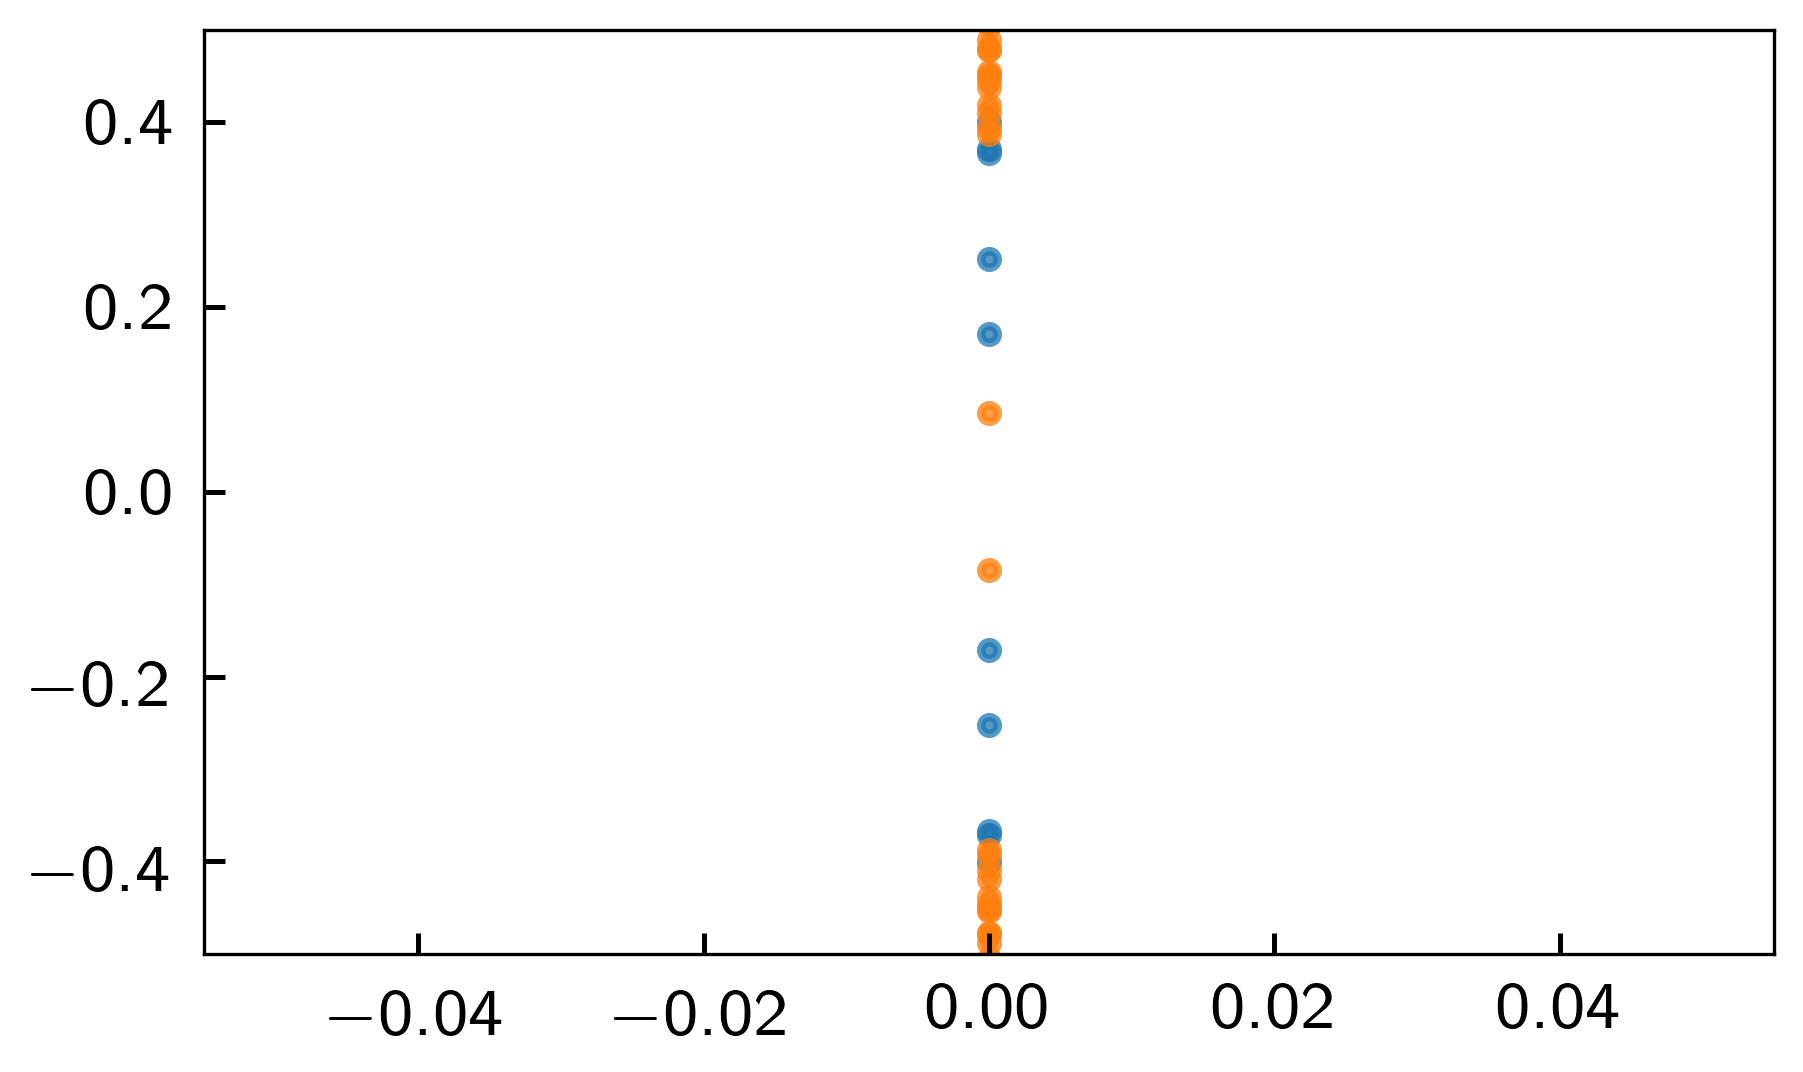

In [34]:
plt.scatter(wss[0]*0, wss[0], alpha=0.5)
plt.scatter(ws_sc*0, ws_sc, alpha=0.5)
plt.ylim(-0.5, 0.5)